## Курсовая работа по курсу:

### "Фреймворк PyTorch для разработки искусственных нейронных сетей"

Загрузка библиотрек:

In [1]:
pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.6 MB/s eta 0:00:00


In [2]:
pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 38.0 MB/s eta 0:00:00


In [3]:
from ast import increment_lineno
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as tt
import torchvision.transforms.functional as TF
from torchvision.utils import  make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import cv2
from PIL import Image

from pathlib import Path

Загрузка и преобразование данных:

In [4]:
DATA_ROOT = Path('/content/drive/MyDrive/Colab Notebooks/leapGestRecog')

In [5]:
tmp_ds = ImageFolder(DATA_ROOT / '00')
CLASSES_NAME = tmp_ds.classes
CLASSES_NAME

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

In [6]:
train_tfms= tt.Compose([
                        tt.Grayscale(num_output_channels=3),
                        tt.Resize([128,128]),
                        tt.RandomHorizontalFlip(),
                        tt.RandomRotation(30),
                        tt.ToTensor(),
                        ])

test_tfms= tt.Compose([
                        tt.Grayscale(num_output_channels=3),
                        tt.Resize([128,128]),
                        tt.ToTensor(),
                        ])

In [7]:
train_ds_list = []
test_ds_list = []
for dir in os.listdir(DATA_ROOT):
  train_ds = ImageFolder(os.path.join(DATA_ROOT,dir),train_tfms)
  test_ds = ImageFolder(os.path.join(DATA_ROOT,dir),test_tfms)
  train_ds_list.append(train_ds)
  test_ds_list.append(test_ds)

train_ds = ConcatDataset(train_ds_list)
test_ds = ConcatDataset(test_ds_list)


In [8]:
LEN_DS = len(train_ds)
LEN_DS

20020

In [9]:
def digit_to_classname(digit):
  for idx,itm in enumerate(CLASSES_NAME):
    if idx == digit:
      return itm

In [10]:
torch.manual_seed(1)

val_split = 0.2
split = int(LEN_DS*val_split)
indices = torch.randperm(LEN_DS)

train_ds = torch.utils.data.Subset(train_ds, indices[split:])
test_ds = torch.utils.data.Subset(test_ds, indices[split:])

len(train_ds), len(test_ds)

(16016, 16016)

In [11]:
train_ds[15000][0].size()

torch.Size([3, 128, 128])

In [12]:
batch_size = 64
train_dl = DataLoader(train_ds,batch_size, shuffle = True, num_workers = 2)
test_dl = DataLoader(test_ds,batch_size, shuffle = False, num_workers = 1)

Проверка и отображение данных:

torch.Size([3, 128, 128])
tensor(3) 04_fist_moved


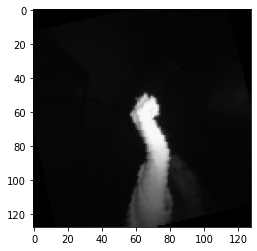

In [13]:
for img, l in train_dl:
  print(img[0].shape)
  print(l[0], digit_to_classname(l[0]))
  plt.imshow(img[0].permute(1,2,0))
  break

In [14]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([]); ax.set_yticks([])
    print(images[0].shape)
    ax.imshow(make_grid(images[:64], nrow=8).permute(1,2,0))
    break

torch.Size([3, 128, 128])


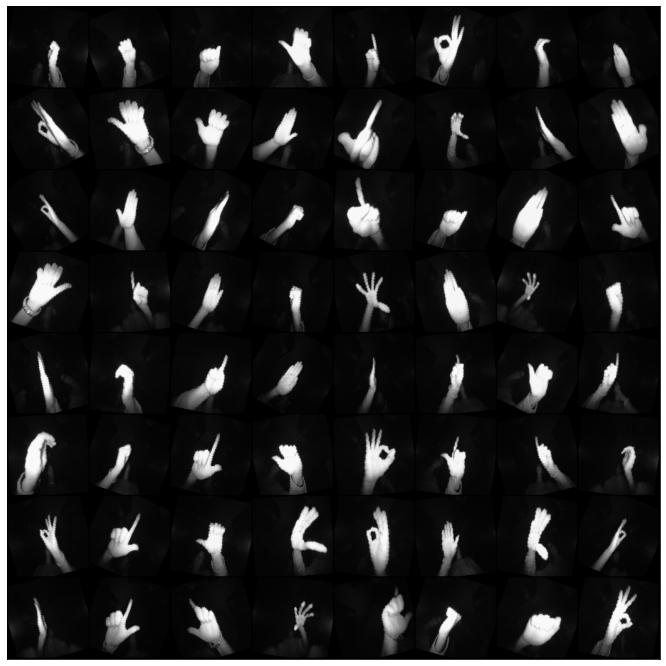

In [15]:
show_batch(train_dl)

In [16]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

Загрузка предобученной модели:

In [17]:
resnet = models.resnet50(pretrained = True)
summary(resnet.to(device), input_size=(3,128,128))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [18]:
for param in resnet.parameters():
  param.requires_grad = False

In [19]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Изменение последнего слоя загруженной модели:

In [20]:
in_features = resnet.fc.in_features
fc = nn.Linear(in_features = in_features, out_features = len(CLASSES_NAME))
resnet.fc = fc

summary(resnet.to(device), input_size = (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

Дообучение загруженной модели:

In [21]:
params_to_update = []
for name, param in resnet.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

In [22]:
from time import time

def train(model, criterion,optimizer,train_dataloader,test_dataloader,print_every,num_epoch):
  steps = 0
  train_losses, val_losses = [],[]

  model.to(device)
  for epoch in range(num_epoch):
    running_loss = 0
    correct_train = 0
    total_train = 0
    start_time = time()
    iter_time = time()

    model.train()
    for i, (images, labels) in enumerate(train_dataloader):
      steps +=1
      images = images.to(device)
      labels = labels.to(device)

      output = model(images)
      loss = criterion(output, labels)

      correct_train += (torch.max(output, dim = 1)[1] == labels).sum()
      total_train += labels.size(0)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      if steps % print_every == 0:
        print(f'Epoch [{epoch+1}]/[{num_epoch}]. Batch [{i+1}]/[{len(train_dataloader)}].', end = ' ')
        print(f'Train_loss {running_loss / steps:.3f}.', end = ' ')
        print(f'Train_acc {correct_train / total_train * 100:.3f}.', end = ' ')
        with torch.no_grad():
          model.eval()
          correct_val, total_val = 0,0
          val_loss = 0
          for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            val_loss += loss.item()

            correct_val += (torch.max(output, dim=1)[1] == labels).sum()
            total_val += labels.size(0)

        print(f'Val loss {val_loss}/{len(test_dataloader):.3f}. Val acc {correct_val}/{total_val*100:.3f}')
        print(f'Took {time() - iter_time:.3f} seconds')
        iter_time = time()

        train_losses.append(running_loss / total_train)
        val_losses.append(val_loss/total_val)

    print(f'Epoch took {time() - start_time}')
    torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')

  return model, train_losses, val_losses


In [23]:
print_every = 50
num_epoch = 10

resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader = test_dl,
    print_every = print_every,
    num_epoch = num_epoch
)

Epoch [1]/[10]. Batch [50]/[251]. Train_loss 1.363. Train_acc 59.531. Val loss 368.73547172546387/251.000. Val acc 9212/1601600.000
Took 4272.870 seconds
Epoch [1]/[10]. Batch [100]/[251]. Train_loss 1.138. Train_acc 66.875. Val loss 239.5647702217102/251.000. Val acc 11510/1601600.000
Took 99.277 seconds
Epoch [1]/[10]. Batch [150]/[251]. Train_loss 0.962. Train_acc 72.438. Val loss 209.56612372398376/251.000. Val acc 11592/1601600.000
Took 101.039 seconds
Epoch [1]/[10]. Batch [200]/[251]. Train_loss 0.850. Train_acc 75.688. Val loss 173.942242115736/251.000. Val acc 12646/1601600.000
Took 99.159 seconds
Epoch [1]/[10]. Batch [250]/[251]. Train_loss 0.768. Train_acc 78.113. Val loss 151.2076397538185/251.000. Val acc 13244/1601600.000
Took 98.986 seconds
Epoch took 4671.433156967163
Epoch [2]/[10]. Batch [49]/[251]. Train_loss 0.101. Train_acc 79.145. Val loss 183.0137470960617/251.000. Val acc 12721/1601600.000
Took 100.617 seconds
Epoch [2]/[10]. Batch [99]/[251]. Train_loss 0.153.

Сохранение модели в файл:

In [24]:
torch.save(resnet, '/content/drive/MyDrive/Colab Notebooks/my_model')

Загрузка модели:

In [17]:
resnet = torch.load('/content/drive/MyDrive/Colab Notebooks/my_model')
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Проверка на тестовой выборке:

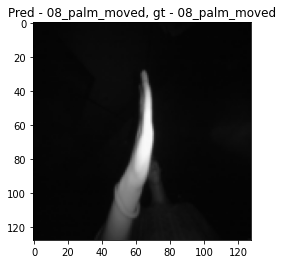

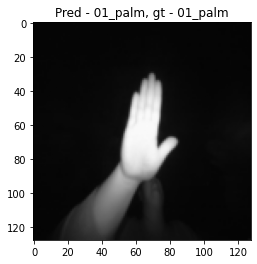

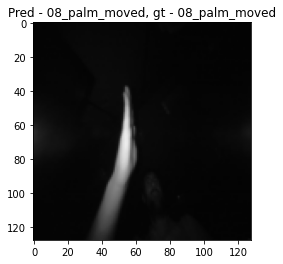

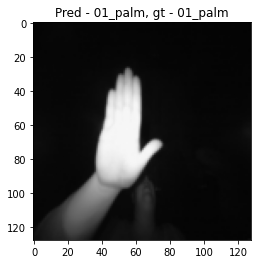

In [18]:
with torch.no_grad():
  for i, data in enumerate(test_dl, 3):
    images, labels = data[0].to(device), data[1].to(device)

    outputs = resnet(images)
    plt.title(f'Pred - {digit_to_classname(outputs[0].argmax())}, gt - {digit_to_classname(labels[0])}')
    plt.imshow(images[0].cpu().permute(1,2,0), cmap='gray')
    plt.show()
    if i>5:
      break

Класс для предсказания:

In [84]:
import cv2
from PIL import Image
from facenet_pytorch import MTCNN
import mediapipe as mp

class FaceDetector(object):

  def __init__(self, mtcnn, filename):
    self.classes_name = ['01_palm',
                          '02_l',
                          '03_fist',
                          '04_fist_moved',
                          '05_thumb',
                          '06_index',
                          '07_ok',
                          '08_palm_moved',
                          '09_c',
                          '10_down']
    self.preprocess = tt.Compose ([
                      tt.Resize([128,128]),
                      tt.Grayscale(num_output_channels=3),
                      tt.ToTensor(),
                      ])
    self.filename = filename
    self.mtcnn = mtcnn
    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    self.model = torch.load('/content/drive/MyDrive/Colab Notebooks/my_model')
    self.model.eval()

  def _draw(self,frame,boxes,probs,landmarks,gests):

    try:
      for box, prob, ld, gest in zip(boxes, probs, landmarks, gests):
        cv2.rectangle(frame,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0,0,255),
                      thickness=2)
        
        cv2.putText(frame,
                    gest, (box[2],box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255),2,cv2.LINE_AA)

        cv2.circle(frame, tuple(ld[0]),5,(0,0,255), -1)
        cv2.circle(frame, tuple(ld[1]),5,(0,0,255), -1)
        cv2.circle(frame, tuple(ld[2]),5,(0,0,255), -1)
        cv2.circle(frame, tuple(ld[3]),5,(0,0,255), -1)
        cv2.circle(frame, tuple(ld[4]),5,(0,0,255), -1)
    except:
      pass

    return frame

  def digit_to_classname(self,digit):
    for idx, itm in enumerate(self.classes_name):
      if idx == digit:
        return itm

  @staticmethod
  def crop_hands(frame,hand_boxes):
    hands=[]
    for i, hand_box in enumerate(hand_boxes):
      pad = int((hand_box[2] - hand_box[0])/4)
      h,w,c = frame.shape
      pad1 = pad if hand_box[1]-pad >= 0 else hand_box[1]
      pad2 = pad if hand_box[3]+pad <= h else h - hand_box[1]
      pad3 = pad if hand_box[0]-pad >= 0 else hand_box[0]
      pad4 = pad if hand_box[2]-pad >= w else w - hand_box[1]
      hands.append(frame[int(hand_box[1]-pad1):int(hand_box[3]+pad2),
            int(hand_box[0]-pad3):int(hand_box[2]+pad4), :])
    return hands

  @staticmethod
  def get_hands(img):
    mpHands = mp.solutions.hands
    hands = mpHands.Hands(False)
    npDraw = mp.solutions.drawing_utils

    results = hands.process(img)
    if results.multi_hand_landmarks:
      hand_boxes = []
      for handLms in results.multi_hand_landmarks:
        h,w,c = img.shape
        x_max = 0
        y_max = 0
        x_min = w
        y_min = h
        for lm in handLms.landmark:
          x,y = int(lm.x*w), int(lm.y*h)
          if x>x_max:
            x_max = x
          if x<x_min:
            x_min = x
          if y>y_max:
            y_max = y
          if y<y_min:
            y_min = y

        hand_box = [x_min, y_min, x_max, y_max]
      hand_boxes.append(hand_box)
    return hand_boxes

  def run(self, path_to_img):

    frame = cv2.imread(path_to_img)

    boxes,probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
    print(boxes)

    hand_boxes = self.get_hands(frame)
    hands = self.crop_hands(frame,hand_boxes)

    gests = []
    for hand in hands:
      hand = cv2.cvtColor(hand, cv2.COLOR_BGR2RGB)
      hand = Image.fromarray(hand)
      hand = self.preprocess(hand)
      hand = hand.to(device).float()
      gest = self.model(hand[None, ...])
      print(gest)
      gest = self.digit_to_classname(gest[0].argmax())
      gests.append(gest)
      print('')
      print(f'Предсказание - {gests}')

    self._draw(frame, boxes, probs, landmarks, gests)

    cv2.imwrite(self.filename, frame)

Получение изображения с камеры:

In [28]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


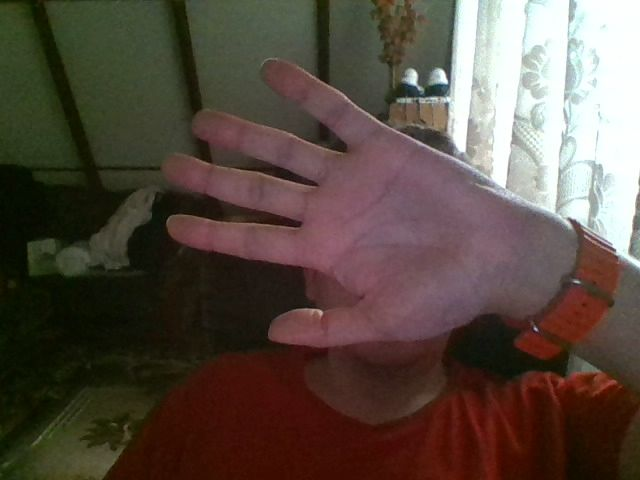

In [29]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [78]:
import os, sys
from PIL import Image, ImageChops, ImageTk
from tkinter import *
from tkinter import ttk
from tkinter import filedialog
from tkinter import messagebox

Предсказание:

In [85]:
mtcnn = MTCNN()
fcd = FaceDetector(mtcnn, filename)
fcd.run(filename)

None
tensor([[ -1.8919,  -5.0175,  -9.2627, -12.5374, -13.0259,  -4.2109,  -5.5602,
         -13.6686, -11.1936,  -4.8575]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

Предсказание - ['01_palm']


Как видно из результата, предсказание '01_palm' полностью соответствует изображению на фотографии.